In [2]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_hierarchical

# Dev: Hierarchical Model

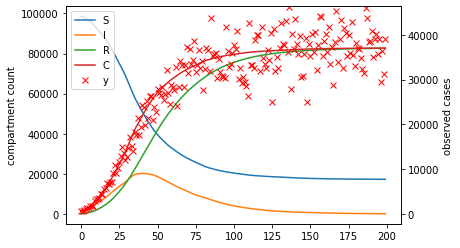

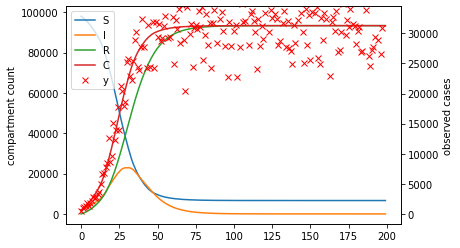

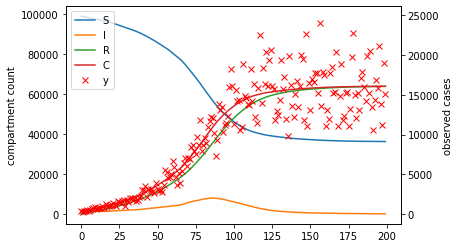

In [5]:
i = 1
num_places = 3
T = 100
T_future = 100
log_scale=False

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SIR_hierarchical(num_places=num_places,
                                        T=T,
                                        T_future=T_future)

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [6]:
#def test_prior_predictive():
T = 100
T_future = 100

num_places = 5

N = 10**np.arange(5)
predictive = Predictive(SIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), 
                     num_places = num_places,
                     T = T, 
                     T_future=100,
                     N = N)

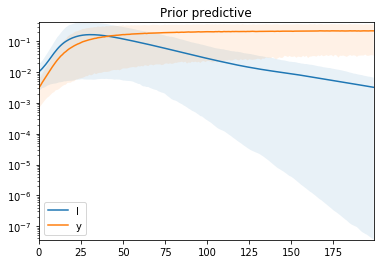

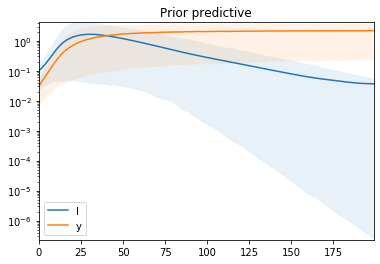

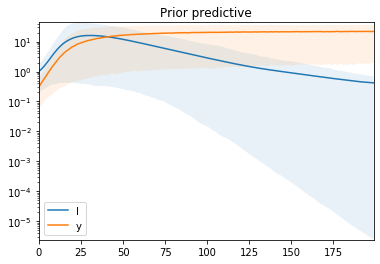

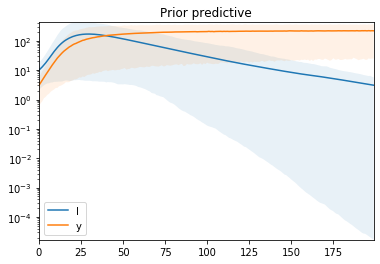

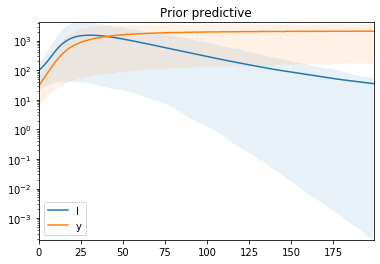

In [7]:
from models import plot_samples

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

In [ ]:
plt.hist(samples['det_rate_'])
plt.show()

for i in range(num_places):
    plt.hist(samples['det_rate'][:,i], density=True, alpha=0.1, bins=30)

plt.show()
# for i in range(2,4):
#     x = plt.hist(samples['gamma'][:,i], bins=30, alpha=0.5)
#     print(x[0].sum())
    
# print

In [ ]:
print(samples.keys())
print(samples['y0'][:,1,...].shape)

# Load and Prep Data

In [8]:
import jhu
import covidtracking
import states

# world data
world = jhu.load_world()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
}

data = {
    'Italy': world.Italy.tot,
    'US': world.US.tot
}

# US state data
US = covidtracking.load_us()
traits = states.uga_traits()

state_pop = { k: traits.totalpop[k] for k in traits.index }
state_data = { k: US[k] for k in US.columns.unique(level=0) }

# combine them
data = dict(data, **state_data)
pop = dict(pop, **state_pop)

# Run Inference

In [10]:
places = ['NY', 'WA']
num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['confirmed'] for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

T = len(confirmed)
N = np.array([pop[place] for place in places])

args = {
    'num_places': num_places,
    'N': N,
    'T': T,
    'drift_scale': 1e-1,
    'det_conc': 100,
}

prob_model = SIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=1000, 
            num_chains=1)

obs = confirmed.values.T

mcmc.run(jax.random.PRNGKey(2), 
         obs = obs,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [02:50<00:00, 11.71it/s, 447 steps of size 2.18e-02. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      I0[0]     51.92     17.63     48.39     26.40     76.93    255.11      1.01
      I0[1]    121.68     22.34    117.52     89.23    156.77    273.06      1.00
  beta[0,0]      0.60      0.10      0.59      0.43      0.74    233.50      1.00
  beta[0,1]      0.59      0.09      0.59      0.46      0.74    358.39      1.00
  beta[0,2]      0.56      0.07      0.55      0.44      0.67    621.97      1.00
  beta[0,3]      0.50      0.06      0.50      0.41      0.60    734.77      1.00
  beta[0,4]      0.45      0.05      0.44      0.35      0.53    712.29      1.00
  beta[0,5]      0.41      0.05      0.40      0.33      0.50    556.05      1.00
  beta[0,6]      0.40      0.05      0.39      0.30      0.47    505.71      1.00
  beta[0,7]      0.40      0.06      0.39      0.31      0.50    503.05      1.01
  beta[0,8]      0.42      0.06      0.41      0.34      0.53    507.06      1.00
  beta[0,9]    

In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
duration = 4
prior_shape = 10
shape = 5

m = 500
n = 10000

with numpyro.handlers.seed(rng_seed=1):
    with numpyro.plate("prior", m):
        rate = numpyro.sample("rate", dist.Gamma(prior_shape, prior_shape))

    #rate = 1
    rate = np.broadcast_to(rate, (n,m))
    x = numpyro.sample("x", dist.Gamma(shape, shape * duration * rate))
    print(x.shape)

    
print(x.mean())
plt.hist(x.mean(axis=0), bins=20)
plt.show()

for i in range(5):
    plt.hist(x[:,i], bins=20, alpha=0.1, lw=1)

In [ ]:
mcmc_samples = None

place = 'WA'
filename = f'out/{place}_samples.npz'
x = np.load(filename, allow_pickle=True)
#print(x['arr_0']['E0'])
mcmc_samples = x['arr_0'].item()
post_pred_samples = x['arr_0'].item()

mcmc_samples['E0']

In [ ]:
print(np.stack([1, 2, 3, 4]))